<a href="https://colab.research.google.com/github/GoetheUniCV/cvproject/blob/main/models/benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model



##1. Setup
###1.1 Python Environment
Almost all required packages are preinstalled, except _kerastuner_. You can install it with `!pip install -U keras-tuner`.

###1.2 Google Drive
####1.2.1 Structure
Create the following directory structure in your Drive:
```
MyDrive
└── cvproject
    ├── COVID-10 Radiography Database
    │   ├── COVID-19
    │   ├── NORMAL
    │   └── Viral Pneumonia
    └── models
```
####1.2.2 Upload COVID-19 Dataset
The directory _COVID-10 Radiography Database_ must contain the dataset from Kaggle (https://www.kaggle.com/tawsifurrahman/covid19-radiography-database).

___


In [3]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [4]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras.preprocessing import image
from google.colab import drive
import matplotlib.cm as cm

from keras import backend as K


In [5]:
# This mounts your Google Drive to the Colab VM.
drive.mount('/content/drive', force_remount=True)

# Foldername in your Drive where you have saved the COVID-19 data.
PROJECT_PATH = '/content/drive/My Drive/cvproject/'
DATABASE_PATH = f'{PROJECT_PATH}/COVID-19 Radiography Database'
MODELS_PATH = f'{PROJECT_PATH}/models'

#assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
#sys.path.append(FOLDERPATH)

Mounted at /content/drive


In [6]:
# Check if database is complete.
try:
  if len(os.listdir(f'{DATABASE_PATH}/COVID-19')) == 1143:
    print('COVID-19 complete.')
  else:
    print('COVID-19 incomplete.')

  if len(os.listdir(f'{DATABASE_PATH}/NORMAL')) == 1341:
    print('NORMAL complete.')
  else:
    print('NORMAL incomplete.')

  if len(os.listdir(f'{DATABASE_PATH}/Viral Pneumonia')) == 1345:
    print('Viral Pneumonia complete.')
  else:
    print('Viral Pneumonia incomplete.')
except FileNotFoundError:
  print("Warning: Some directories are missing!")



COVID-19 complete.
NORMAL complete.
Viral Pneumonia complete.


In [7]:
# Show label name and its encoded value:
class_names =  ["COVID-19","NORMAL","Viral Pneumonia"]

for i, class_name in enumerate(class_names):
    print(f'{class_name}: {i}')

COVID-19: 0
NORMAL: 1
Viral Pneumonia: 2


In [8]:
# NOTE: Bildgröße aller Bilder wird auf 244 x 244 geändert. Leider sind die
#       Covid Bilder sehr klein. Normale und Lungenentzündung sind 1024 x 1024.

# NOTE: removed '= defect_tree ='

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATABASE_PATH,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(244, 244),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 3829 files belonging to 3 classes.
Using 3064 files for training.
Found 3829 files belonging to 3 classes.
Using 765 files for validation.


In [10]:
# Defining the CNNs.
model_1 = tf.keras.models.Sequential([
  layers.Conv2D(64, 5, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_2 = tf.keras.models.Sequential([
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_3 = tf.keras.models.Sequential([
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_4 = tf.keras.models.Sequential([
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_5 = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3, activation= 'softmax')
])

model_6 = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.15),
  layers.Dense(3, activation= 'softmax')
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])

model_7 = tf.keras.models.Sequential([
  data_augmentation,
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.15),
  layers.Dense(3, activation= 'softmax')
])

models = [model_1,
          model_2,
          model_3,
          model_4,
          model_5,
          model_6,
          model_7
          ]

#####################################################################
Model 1
#####################################################################
Epoch 1/20
96/96 [==============================] - 1169s 11s/step - loss: 6136.7876 - accuracy: 0.6175 - val_loss: 2.0042 - val_accuracy: 0.8444
Epoch 2/20
96/96 [==============================] - 55s 538ms/step - loss: 0.9172 - accuracy: 0.9089 - val_loss: 1.9543 - val_accuracy: 0.8680
Epoch 3/20
96/96 [==============================] - 54s 537ms/step - loss: 0.2996 - accuracy: 0.9704 - val_loss: 2.1893 - val_accuracy: 0.8693
Epoch 4/20
96/96 [==============================] - 54s 536ms/step - loss: 0.1664 - accuracy: 0.9800 - val_loss: 2.3400 - val_accuracy: 0.8784
Epoch 5/20
96/96 [==============================] - 54s 537ms/step - loss: 0.1506 - accuracy: 0.9855 - val_loss: 2.3757 - val_accuracy: 0.8719
Epoch 6/20
96/96 [==============================] - 55s 540ms/step - loss: 0.0616 - accuracy: 0.9892 - val_loss: 2.6114 - val_accuracy

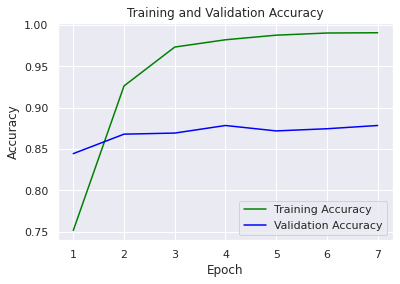

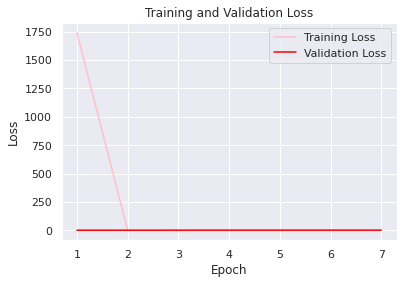

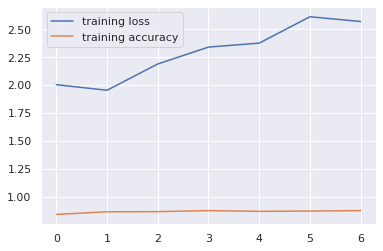

#####################################################################
#####################################################################
Model 2
#####################################################################
Epoch 1/20
96/96 [==============================] - 104s 1s/step - loss: 7396.8132 - accuracy: 0.6113 - val_loss: 166.2798 - val_accuracy: 0.6797
Epoch 2/20
96/96 [==============================] - 55s 540ms/step - loss: 37.3286 - accuracy: 0.8766 - val_loss: 11.1425 - val_accuracy: 0.9242
Epoch 3/20
96/96 [==============================] - 55s 540ms/step - loss: 2.3557 - accuracy: 0.9761 - val_loss: 11.1532 - val_accuracy: 0.9098
Epoch 4/20
96/96 [==============================] - 55s 540ms/step - loss: 1.0836 - accuracy: 0.9840 - val_loss: 9.5136 - val_accuracy: 0.9333
Epoch 5/20
96/96 [==============================] - 55s 538ms/step - loss: 0.8981 - accuracy: 0.9850 - val_loss: 10.3741 - val_accuracy: 0.9111
Epoch 6/20
96/96 [==============================] - 55s 540m

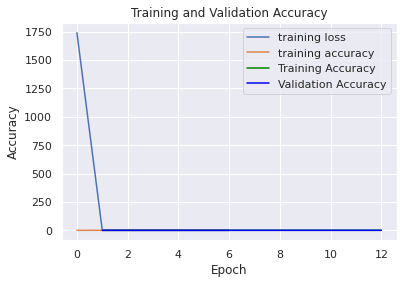

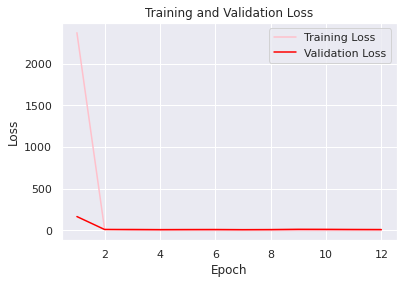

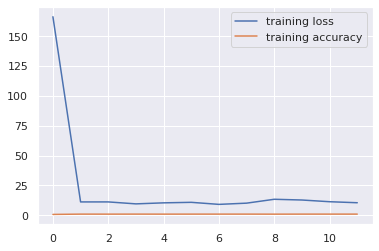

#####################################################################
#####################################################################
Model 3
#####################################################################
Epoch 1/20


ResourceExhaustedError: ignored

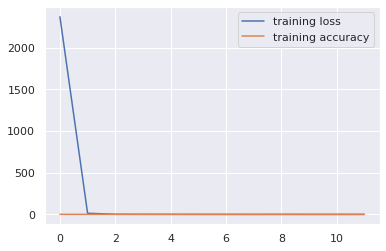

In [11]:
for i in range(0, len(models)):
  # TODO: improve visualization
  print('#####################################################################')
  print(f'Model {i+1}')
  print('#####################################################################')
  
  # Get first model and remove it from list.
  model = models.pop(0) 
  
  # Avoid overfitting...
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

  # Compile the model.
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Fit the model.
  history=model.fit(train_data,
                    validation_data=test_data,
                    batch_size=32,epochs = 20,
                    callbacks=[early])

  # Evaluate the model.
  model.evaluate(test_data)

  # plotting training values
  sns.set()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  #accuracy plot
  plt.plot(epochs, acc, color='green', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.figure()

  #loss plot
  plt.plot(epochs, loss, color='pink', label='Training Loss')
  plt.plot(epochs, val_loss, color='red', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  #train data accuracy and loss
  plt.plot(history.history['val_loss'], label = 'training loss')
  plt.plot(history.history['val_accuracy'], label = 'training accuracy')
  plt.legend()
  plt.show()

  #test data accuracy and loss
  plt.plot(history.history['loss'], label = 'training loss')
  plt.plot(history.history['accuracy'], label = 'training accuracy')
  plt.legend()

  # Save model as .h5 file.
  model.save(f'{MODELS_PATH}/model_2021-01-20_{i+1}.h5')

  # Delete the data for this model from RAM/GPU/wherever...
  del model
  del history
  K.clear_session()

  print('#####################################################################')